## Identifying/combining risk factors for brain atrophy from different cohorts
#### Presenter: Yi-Han Hu, Laboratory of Epidemiology & Population Science, NIA 

![](https://github.com/wolfhank/final-project/raw/master/Idea.png)

### Objectives:
- Identify the top influential features/risk factors in terms of brain volumn (Main focus for today's talk)
- Combine the rsik factors from different cohorts

### Methods:
- Data: Simulated data based on a real data set
    - Real data from large cohort with more than 5000 subjects with 2000 and over features
        - Preprocessed data
            - Recode string type variables and create dummy variables
            - Remove date or string variables
            - Imputation
                - Logical imputation (some types of item nonresponse. ex., smoking quantity for non-smokers)
                - Mean imputation by group (age bin and sex)
        - Create dummy variables for categorical variables with >= 3 categories
        - Normalization for all continuous/ordinal variables
    - 1500 subjects with more than 700 features
    - Outcome: Total Brain Volumn <= 25% (simulated)
- Approach:
    - **Run model(s) directly**:
    Preprocess data and throw all the features in the model(s), and see which features were select from the model
    - **PCA --> model**:
    Run PCA using all the features in the data set and throw those PCs into model(s)
    - **Cluster --> PCA --> model**:
    Clustering all the features to identify similar variables and run PCA for each cluster and then modeling.  

### Import library

In [1]:
#Import library
import pandas as pd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 900)
pd.set_option('display.width', 1000)
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

### Retrieve Data

In [29]:
# Retrieve simulated data file from url
url = "https://github.com/wolfhank/final-project/blob/master/Fake_data.pkl?raw=true"
Fake_data = pd.read_pickle(url)
Fake_data.shape

(1500, 731)

### Data Overview

In [30]:
Fake_data.describe()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_114,col_115,col_116,col_117,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,col_129,col_130,col_131,col_132,col_133,col_134,col_135,col_136,col_137,col_138,col_139,col_140,col_141,col_142,col_143,col_144,col_145,col_146,col_147,col_148,col_149,col_150,col_151,col_152,col_153,col_154,col_155,col_156,col_157,col_158,col_159,col_160,col_161,col_162,col_163,col_164,col_165,col_166,col_167,col_168,col_169,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179,col_180,col_181,col_182,col_183,col_184,col_185,col_186,col_187,col_188,col_189,col_190,col_191,col_192,col_193,col_194,col_195,col_196,col_197,col_198,col_199,col_200,col_201,col_202,col_203,col_204,col_205,col_206,col_207,col_208,col_209,col_210,col_211,col_212,col_213,col_214,col_215,col_216,col_217,col_218,col_219,col_220,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,col_235,col_236,col_237,col_238,col_239,col_240,col_241,col_242,col_243,col_244,col_245,col_246,col_247,col_248,col_249,col_250,col_251,col_252,col_253,col_254,col_255,col_256,col_257,col_258,col_259,col_260,col_261,col_262,col_263,col_264,col_265,col_266,col_267,col_268,col_269,col_270,col_271,col_272,col_273,col_274,col_275,col_276,col_277,col_278,col_279,col_280,col_281,col_282,col_283,col_284,col_285,col_286,col_287,col_288,col_289,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299,col_300,col_301,col_302,col_303,col_304,col_305,col_306,col_307,col_308,col_309,col_310,col_311,col_312,col_313,col_314,col_315,col_316,col_317,col_318,col_319,col_320,col_321,col_322,col_323,col_324,col_325,col_326,col_327,col_328,col_329,col_330,col_331,col_332,col_333,col_334,col_335,col_336,col_337,col_338,col_339,col_340,col_341,col_342,col_343,col_344,col_345,col_346,col_347,col_348,col_349,col_350,col_351,col_352,col_353,col_354,col_355,col_356,col_357,col_358,col_359,col_360,col_361,col_362,col_363,col_364,col_365,col_366,col_367,col_368,col_369,col_370,col_371,col_372,col_373,col_374,col_375,col_376,col_377,col_378,col_379,col_380,col_381,col_382,col_383,col_384,col_385,col_386,col_387,col_388,col_389,col_390,col_391,col_392,col_393,col_394,col_395,col_396,col_397,col_398,col_399,col_400,col_401,col_402,col_403,col_404,col_405,col_406,col_407,col_408,col_409,col_410,col_411,col_412,col_413,col_414,col_415,col_416,col_417,col_418,col_419,col_420,col_421,col_422,col_423,col_424,col_425,col_426,col_427,col_428,col_429,col_430,col_431,col_432,col_433,col_434,col_435,col_436,col_437,col_438,col_439,col_440,col_441,col_442,col_443,col_444,col_445,col_446,col_447,col_448,col_449,col_450,col_451,col_452,col_453,col_454,col_455,col_456,col_457,col_458,col_459,col_460,col_461,col_462,col_463,col_464,col_465,col_466,col_467,col_468,col_469,col_470,col_471,col_472,col_473,col_474,col_475,col_476,col_477,col_478,col_479,col_480,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_501,col_502,col_503,col_504,col_505,col_506,col_507,col_508,col_509,col_510,col_511,col_512,col_513,col

## Transpose dataset --> Clustering features 

In [31]:
Fake_data_tr = Fake_data.drop(["Y"], axis=1).transpose()
print(Fake_data_tr.shape)
Fake_data_tr.head()

(730, 1500)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,...,1050,1051,1052,1053,1054,1055,1056,1057,1058,1059,1060,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152,1153,1154,1155,1156,1157,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210,1211,1212,1213,1214,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1226,1227,1228,1229,1230,1231,1232,1233,1234,1235,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279,1280,1281,1282,1283,1284,1285,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295,1296,1297,1298,1299,1300,1301,1302,1303,1304,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330,1331,1332,1333,1334,1335,1336,1337,1338,1339,1340,1341,1342,1343,1344,1345,1346,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451,1452,1453,1454,1455,1456,1457,1458,1459,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
col_1,0.402009,0.847794,-0.489563,1.293580,-0.935349,1.

## Clustering the features using the transposed dataset

In [32]:
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
from collections import Counter

In [33]:
def dbscan_grid_search(X_data, lst, clst_count, eps_space = 0.5,
                       min_samples_space = 5, min_clust = 0, max_clust = 10, min_silh_score = 0.2):
    # Importing counter to count the amount of data in each cluster
    from collections import Counter
    # Starting a tally of total iterations
    n_iterations = 0
    # Looping over each combination of hyperparameters
    for eps_val in eps_space:
        for samples_val in min_samples_space:
            dbscan_grid = DBSCAN(eps = eps_val,
                                 min_samples = samples_val)
            # fit_transform
            clusters = dbscan_grid.fit_predict(X = X_data)
            # Counting the amount of data in each cluster
            cluster_count = Counter(clusters)
            # Saving the number of clusters in labels, ignoring noise if present.
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            n_noise = list(clusters).count(-1)
            # Saving the silhouette_score
            silhouette_score = metrics.silhouette_score(X_data, clusters)
            # Increasing the iteration tally with each run of the loop
            n_iterations += 1
            # Appending the lst each time n_clusters criteria is reached
            if n_clusters >= min_clust and n_clusters <= max_clust and silhouette_score >= min_silh_score:
                dbscan_clusters.append([eps_val,
                                        samples_val,
                                        n_clusters, 
                                        n_noise, 
                                        silhouette_score])
                clst_count.append(cluster_count)

    # Printing grid search summary information
    print(f"""Search Complete. \nYour list is now of length {len(lst)}. """)
    print(f"""Hyperparameter combinations checked: {n_iterations}. \n""")

In [34]:
dbscan_clusters = []
cluster_count   = []
dbscan_grid_search(X_data = Fake_data_tr,
                   lst = dbscan_clusters,
                   clst_count = cluster_count,
                   eps_space = np.arange(30, 50, 1),
                   min_samples_space = np.arange(5, 10, 1),
                   min_clust = 3,
                   max_clust = 150, 
                   min_silh_score = 0.1)

Search Complete. 
Your list is now of length 35. 
Hyperparameter combinations checked: 100. 



In [35]:
df_dbscan_clusters = pd.concat([pd.DataFrame(dbscan_clusters).rename(columns={0:'eps_val', 1:'samples_val', 2:'n_clusters', 3:'n_noise', 4:'silhouette_score'}), pd.DataFrame(cluster_count)], axis=1)
df_dbscan_clusters.sort_values(by=['silhouette_score', 'n_clusters', 'n_noise'], ascending=False).head(15)

,eps_val,samples_val,n_clusters,n_noise,silhouette_score,-1,0,9,1,2,14,3,4,5,13,6,10,12,7,8,11,15
9,33,5,15,199,0.146471,199,427,5.0,14,10,5.0,10.0,7.0,7.0,5.0,9.0,9.0,6.0,5.0,6.0,6.0,NaN
14,34,5,14,191,0.144545,191,440,5.0,14,10,NaN,10.0,7.0,7.0,5.0,9.0,9.0,6.0,5.0,6.0,6.0,NaN
19,35,5,13,179,0.138361,179,465,9.0,11,10,NaN,7.0,7.0,9.0,NaN,5.0,6.0,5.0,6.0,5.0,6.0,NaN
15,34,6,11,209,0.133848,209,437,9.0,14,10,NaN,10.0,7.0,7.0,NaN,6.0,6.0,NaN,9.0,6.0,NaN,NaN
6,32,5,16,214,0.131920,214,408,6.0,14,10,5.0,6.0,7.0,7.0,6.0,9.0,5.0,5.0,5.0,8.0,9.0,6.0
24,36,5,12,163,0.131858,163,488,6.0,10,7,NaN,11.0,9.0,5.0,NaN,9.0,6.0,NaN,6.0,5.0,5.0,NaN
10,33,6,10,225,0.130264,225,427,6.0,14,10,NaN,10.0,7.0,7.0,NaN,6.0,NaN,NaN,9.0,9.0,NaN,NaN
29,37,5,11,146,0.130100,146,513,6.0,7,11,NaN,9.0,5.0,9.0,NaN,6.0,6.0,NaN,5.0,7.0,NaN,NaN
20,35,6,10,197,0.128266,197,462,6.0,11,10,NaN,7.0,7.0,9.0,NaN,6.0,NaN,NaN,9.0,6.0,NaN,NaN
0,30,5,15,239,0.126175,239,384,15.0,13,10,6.0,6.0,7.0,7.0,5.0,5.0,8.0,5.0,8.0,6.0,6.0,NaN


In [36]:
# Compute DBSCAN
db = DBSCAN(eps= 36, min_samples = 5).fit(Fake_data_tr)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [37]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

cluster_count = pd.DataFrame.from_dict(Counter(labels), orient='index').reset_index().rename(columns={'index':'cluster ID', 0:'Number of vars'})

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Fake_data_tr, labels))
print("\nThe amount of vars in each cluster:")
print(cluster_count)

Estimated number of clusters: 12
Estimated number of noise points: 163
Silhouette Coefficient: 0.132

The amount of vars in each cluster:
    cluster ID  Number of vars
0           -1             163
1            0             488
2            1              10
3            2               7
4            3              11
5            4               9
6            5               5
7            6               9
8            7               6
9           11               5
10           8               5
11           9               6
12          10               6


Silhouette Coefficient: 0.132


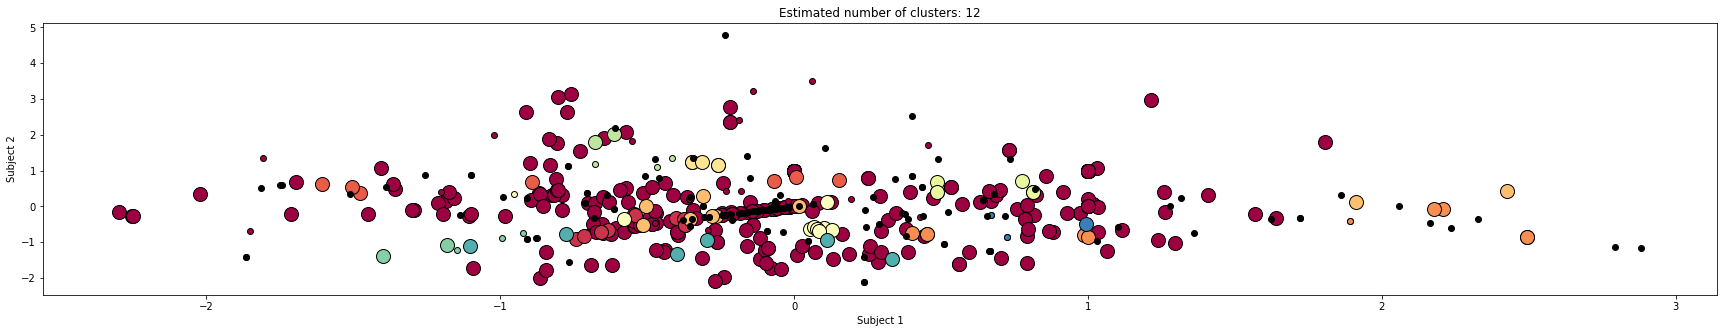

In [38]:
# Plot result
fig=plt.figure(figsize=(30, 5))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = Fake_data_tr[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = Fake_data_tr[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlabel("Subject 1")
plt.ylabel("Subject 2")

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(Fake_data_tr, labels))
plt.show()

In [39]:
cluster_label = pd.Series(Fake_data_tr.index, db.labels_).sort_index(ascending=True)

### Create final datasets - PCA
- Create imputed data for PCA
- Run PCA for each cluster (if vars don't fall into any clusters keep it as is)
- Keep the 1st PC for each cluster

In [40]:
Fake_X = Fake_data.drop(["Y"], axis=1)
print(Fake_X.shape)
Fake_X.head()

(1500, 730)


,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,col_20,col_21,col_22,col_23,col_24,col_25,col_26,col_27,col_28,col_29,col_30,col_31,col_32,col_33,col_34,col_35,col_36,col_37,col_38,col_39,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50,col_51,col_52,col_53,col_54,col_55,col_56,col_57,col_58,col_59,col_60,col_61,col_62,col_63,col_64,col_65,col_66,col_67,col_68,col_69,col_70,col_71,col_72,col_73,col_74,col_75,col_76,col_77,col_78,col_79,col_80,col_81,col_82,col_83,col_84,col_85,col_86,col_87,col_88,col_89,col_90,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,col_101,col_102,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,col_112,col_113,col_114,col_115,col_116,col_117,col_118,col_119,col_120,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,col_129,col_130,col_131,col_132,col_133,col_134,col_135,col_136,col_137,col_138,col_139,col_140,col_141,col_142,col_143,col_144,col_145,col_146,col_147,col_148,col_149,col_150,col_151,col_152,col_153,col_154,col_155,col_156,col_157,col_158,col_159,col_160,col_161,col_162,col_163,col_164,col_165,col_166,col_167,col_168,col_169,col_170,col_171,col_172,col_173,col_174,col_175,col_176,col_177,col_178,col_179,col_180,col_181,col_182,col_183,col_184,col_185,col_186,col_187,col_188,col_189,col_190,col_191,col_192,col_193,col_194,col_195,col_196,col_197,col_198,col_199,col_200,col_201,col_202,col_203,col_204,col_205,col_206,col_207,col_208,col_209,col_210,col_211,col_212,col_213,col_214,col_215,col_216,col_217,col_218,col_219,col_220,col_221,col_222,col_223,col_224,col_225,col_226,col_227,col_228,col_229,col_230,col_231,col_232,col_233,col_234,col_235,col_236,col_237,col_238,col_239,col_240,col_241,col_242,col_243,col_244,col_245,col_246,col_247,col_248,col_249,col_250,col_251,col_252,col_253,col_254,col_255,col_256,col_257,col_258,col_259,col_260,col_261,col_262,col_263,col_264,col_265,col_266,col_267,col_268,col_269,col_270,col_271,col_272,col_273,col_274,col_275,col_276,col_277,col_278,col_279,col_280,col_281,col_282,col_283,col_284,col_285,col_286,col_287,col_288,col_289,col_290,col_291,col_292,col_293,col_294,col_295,col_296,col_297,col_298,col_299,col_300,col_301,col_302,col_303,col_304,col_305,col_306,col_307,col_308,col_309,col_310,col_311,col_312,col_313,col_314,col_315,col_316,col_317,col_318,col_319,col_320,col_321,col_322,col_323,col_324,col_325,col_326,col_327,col_328,col_329,col_330,col_331,col_332,col_333,col_334,col_335,col_336,col_337,col_338,col_339,col_340,col_341,col_342,col_343,col_344,col_345,col_346,col_347,col_348,col_349,col_350,col_351,col_352,col_353,col_354,col_355,col_356,col_357,col_358,col_359,col_360,col_361,col_362,col_363,col_364,col_365,col_366,col_367,col_368,col_369,col_370,col_371,col_372,col_373,col_374,col_375,col_376,col_377,col_378,col_379,col_380,col_381,col_382,col_383,col_384,col_385,col_386,col_387,col_388,col_389,col_390,col_391,col_392,col_393,col_394,col_395,col_396,col_397,col_398,col_399,col_400,col_401,col_402,col_403,col_404,col_405,col_406,col_407,col_408,col_409,col_410,col_411,col_412,col_413,col_414,col_415,col_416,col_417,col_418,col_419,col_420,col_421,col_422,col_423,col_424,col_425,col_426,col_427,col_428,col_429,col_430,col_431,col_432,col_433,col_434,col_435,col_436,col_437,col_438,col_439,col_440,col_441,col_442,col_443,col_444,col_445,col_446,col_447,col_448,col_449,col_450,col_451,col_452,col_453,col_454,col_455,col_456,col_457,col_458,col_459,col_460,col_461,col_462,col_463,col_464,col_465,col_466,col_467,col_468,col_469,col_470,col_471,col_472,col_473,col_474,col_475,col_476,col_477,col_478,col_479,col_480,col_481,col_482,col_483,col_484,col_485,col_486,col_487,col_488,col_489,col_490,col_491,col_492,col_493,col_494,col_495,col_496,col_497,col_498,col_499,col_500,col_501,col_502,col_503,col_504,col_505,col_506,col_507,col_508,col_509,col_510,col_511,col_512,col_513,col

In [41]:
def PCA_Cluster(X_data, cluster_data, n_component = 1):
    appended_data = []
    pca_varratio = []
    # Importing PCA
    from sklearn import decomposition
    pca = decomposition.PCA(n_components = n_component)

    # Looping over each cluster
    for cluster in np.unique(cluster_data.index):
        if cluster >= 0 :
            cluster_var_list = cluster_data[cluster_data.index == cluster].values.tolist()
            # fit_transform
            pca_fit = pca.fit(X_data[cluster_var_list])
            PC_data = pca.fit_transform(X_data[cluster_var_list])        
            appended_data.append(pd.DataFrame(PC_data).rename(columns={0:f"""PC1_cluster_{cluster+1}"""}))
            pca_varratio.append(pd.DataFrame(pca_fit.explained_variance_ratio_).rename(columns={0:f"""PC_var_cluster_{cluster+1}"""}))
        elif cluster == -1:
            cluster_var_list = cluster_data[cluster_data.index == cluster].values.tolist()
            appended_data.append(X_data[cluster_var_list].reset_index(drop=True))

    new_df = pd.concat(appended_data, axis=1)
    pca_varratio_df = pd.concat(pca_varratio, axis=1)
    return new_df, pca_varratio_df.T

In [42]:
cluster_PCA_data, PCA_Var_Cluster = PCA_Cluster(X_data = Fake_X, cluster_data = cluster_label)

In [43]:
print(cluster_PCA_data.shape)
cluster_PCA_data.head()

(1500, 175)


,col_1,col_319,col_328,col_329,col_332,col_334,col_336,col_338,col_346,col_351,col_353,col_355,col_356,col_357,col_359,col_314,col_362,col_366,col_371,col_373,col_375,col_376,col_381,col_383,col_394,col_397,col_403,col_408,col_415,col_417,col_421,col_363,col_423,col_311,col_304,col_151,col_156,col_161,col_164,col_166,col_168,col_169,col_170,col_171,col_176,col_178,col_183,col_187,col_194,col_308,col_197,col_213,col_227,col_244,col_248,col_251,col_256,col_263,col_267,col_280,col_281,col_288,col_289,col_293,col_302,col_206,col_424,col_427,col_428,col_621,col_625,col_626,col_632,col_633,col_634,col_642,col_646,col_655,col_660,col_661,col_662,col_665,col_669,col_613,col_670,col_680,col_685,col_689,col_691,col_695,col_700,col_706,col_707,col_709,col_713,col_714,col_720,col_722,col_724,col_675,col_604,col_600,col_599,col_445,col_456,col_459,col_472,col_486,col_489,col_493,col_501,col_511,col_516,col_519,col_527,col_528,col_529,col_532,col_534,col_535,col_598,col_596,col_586,col_583,col_581,col_580,col_145,col_579,col_562,col_560,col_557,col_553,col_549,col_548,col_569,col_140,col_365,col_29,col_9,col_48,col_83,col_66,col_104,col_113,col_21,col_129,col_12,col_78,col_86,col_79,col_33,col_115,col_36,col_76,col_54,col_39,col_117,col_58,col_96,col_75,col_108,col_42,col_136,PC1_cluster_1,PC1_cluster_2,PC1_cluster_3,PC1_cluster_4,PC1_cluster_5,PC1_cluster_6,PC1_cluster_7,PC1_cluster_8,PC1_cluster_9,PC1_cluster_10,PC1_cluster_11,PC1_cluster_12
0,0.402009,-0.133867,0.820187,-0.109776,0.267092,-0.093607,-0.038792,-0.355091,0.655267,0.366087,0.735605,-0.017917,-0.209918,-0.017917,-1.750584,-0.712318,0.680157,-0.348184,-1.136568,-0.910108,-0.355091,1.102221,0.665936,-0.879163,2.328068,-0.378757,0.106343,0.642771,-0.141306,-0.28899,-0.072998,0.510726,-1.865558,0.048411,0.246238,-0.219403,-1.742067,-0.06955,-0.025343,-0.074043,-0.118291,1.279194,0.063857,0.017917,1.720741,1.031298,-0.506702,1.361426,-0.109622,0.23746,0.238170,-0.078326,0.379337,0.387995,-0.238721,-1.812886,-1.509600,-0.611529,-0.305365,2.058985,-0.025343,-0.065596,-0.185819,0.716823,-0.160485,1.317595,-0.063518,-0.765537,-0.093607,-0.288223,-0.074065,-0.178688,-0.112744,-0.704399,1.622641,-0.114035,1.861427,-0.155974,-0.704399,-0.342913,-0.611529,-0.057096,-1.865558,-1.100831,0.287799,0.664780,-0.050735,0.665936,-0.352482,-0.056741,-0.244671,0.665936,-0.139945,0.491257,0.402009,-0.110012,0.400590,-0.989016,0.436176,-0.098597,-0.175397,-0.769014,-0.062177,-0.182089,-0.095223,-0.137719,-0.017917,-0.308643,2.235275,-0.634910,-0.216082,-0.078326,-0.172459,0.238170,0.642771,-0.084408,-0.08287,-0.071842,-0.459418,0.522863,-0.06718,-0.017917,-0.04009,-0.095546,-0.062177,-0.473991,0.343277,2.792905,-1.256355,-1.100831,-0.907775,0.063857,-0.17725,-0.056741,-0.231885,0.510726,-0.033874,-0.017917,0.377366,-0.087802,-0.234314,1.720741,-0.907775,-0.308643,-0.025343,-0.047660,-0.065596,-0.017917,-0.609641,-0.149480,-0.074065,-1.390173,2.162354,-0.128891,2.881346,0.048411,0.439071,-0.14012,0.436176,-0.679720,0.241621,-0.106583,-0.769014,6.006093,-1.667729,2.067976,4.834432,0.726170,-0.681027,-0.153674,-1.498042,-1.272671,-2.635125,-0.892040,1.709798
1,0.847794,-0.133867,0.492350,-0.109776,0.267092,-0.682768,-0.725588,-0.557554,-0.257253,-0.190365,1.321862,-0.017917,-0.369212,-0.017917,0.591973,0.081131,0.336397,-0.348184,-0.244768,0.223797,-0.557554,-0.568619,-1.256944,-0.879163,-0.342093,-0.378757,1.637977,0.186916,-0.141306,-0.28899,-0.072998,-1.047400,-1.412475,-0.976770,-0.586834,-0.219403,0.588307,-0.06955,-0.025343,-0.074043,-0.118291,0.013936,0.063857,0.017917,-0.317396,-0.969652,0.861075,-0.734524,-0.109622,-1.40682,-2.126838,-0.078326,-0.824721,-0.352638,-0.238721,0.503239,0.339325,-0.076670,-0.305365,0.003299,-0.025343,0.057609,-0.185819,-0.261922,1.397372,0.231163,0.148170,-1.555424,-0.682768,-0.288223,-0.074065,-0.178688,-0.112744,0.375750,-0.356953,-0.114035,0.329900,-0.155974,0.375750,1.342754,-0.076670,-0.057096,-1.412475,0.877671,-0.488539,-1.258147,-0.050735,-1.256944,0.264434,

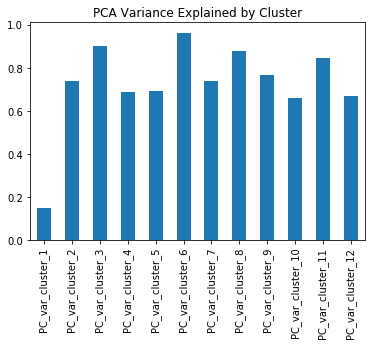

In [44]:
# print(PCA_Var_Cluster.shape)
PCA_Var_Cluster.plot(kind='bar', title='PCA Variance Explained by Cluster', legend=None);

In [45]:
Fake_Y = Fake_data['Y']
print(Fake_Y.shape)
Fake_Y.head()

(1500,)


0    0
1    0
2    0
3    1
4    0
Name: Y, dtype: int64

### Ensemble methods: boosting - Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier  #GBM algorithm
from sklearn.model_selection import GridSearchCV   #Perforing grid search
from sklearn.model_selection import cross_val_score, KFold   #Additional scklearn functions
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn import linear_model, decomposition
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

In [46]:
def modelfit(alg, dtrain, predictors, outcome, performCV=True, printFeatureImportance=True, cv_folds = 5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], outcome)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], outcome, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(outcome.values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(outcome, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        %matplotlib inline
        fig=plt.figure(figsize=(5, 30))
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.sort_values(ascending=False).nlargest(50).plot(kind='barh', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.836
AUC Score (Train): 0.974844
CV Score : Mean - 0.563066 | Std - 0.02706796 | Min - 0.4912606 | Max - 0.5901675


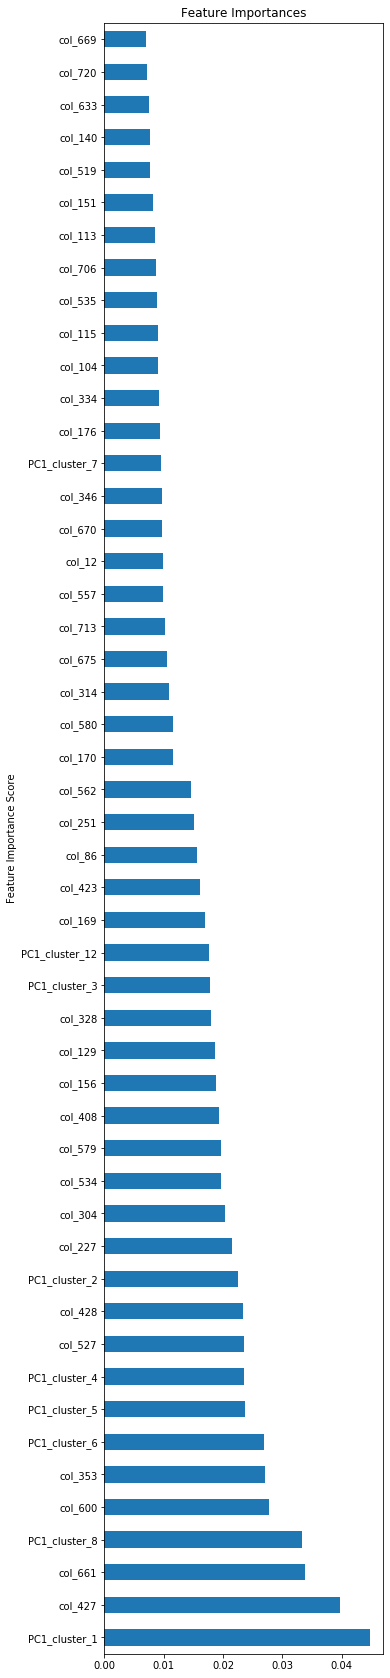

In [47]:
kf = KFold(n_splits=10, shuffle=True, random_state=99)
#Choose all predictors except target
predictors = [x for x in cluster_PCA_data.columns]
gbm0 = GradientBoostingClassifier(random_state=99)
modelfit(gbm0, cluster_PCA_data, predictors, Fake_Y, cv_folds=kf)

In [48]:
gbm0

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=99, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [53]:
gbm = GradientBoostingClassifier(random_state=99)

param_grid = {
    'learning_rate': [0.1, 0.01, 0.0001],
    # Number of trees in random forest
    "n_estimators": range(80, 101, 10),
    "max_depth": [3, 6, 9]
}

kf = KFold(n_splits=10, shuffle=True, random_state=99)

gsearch2 = GridSearchCV(gbm, param_grid = param_grid, scoring='roc_auc', n_jobs= -1, cv= kf)
gsearch2.fit(cluster_PCA_data, Fake_Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=99, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_...
                                                  n_iter_no_change=None,
                               

In [54]:
print("Model Report")
print("Best parameter (CV score=%0.3f):" % gsearch2.best_score_)

print(gsearch2.best_params_)
print(gsearch2.best_estimator_)

print("\nModel Estimator")
print('GBM:', gsearch2)

Model Report
Best parameter (CV score=0.567):
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 80}
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=99, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Model Estimator
GBM: GridSearchCV(cv=KFold(n_splits=10, random_state=99, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                 

In [55]:
best_model = gsearch2.best_estimator_


Model Report
Accuracy : 0.8187
AUC Score (Train): 0.962179
CV Score : Mean - 0.5668398 | Std - 0.02629283 | Min - 0.5002648 | Max - 0.599645


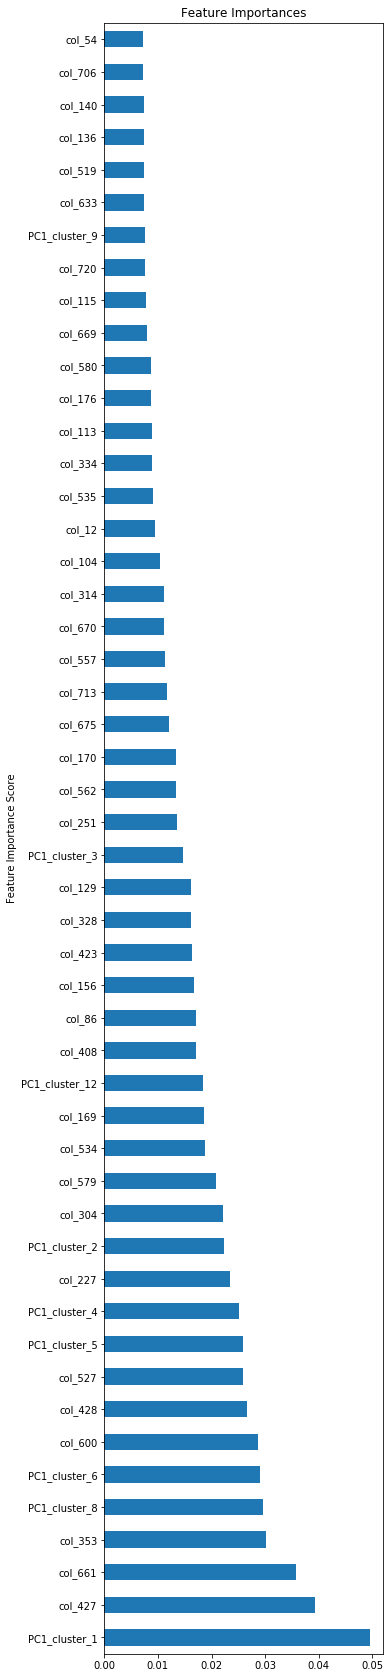

In [56]:
kf = KFold(n_splits=10, shuffle=True, random_state=99)
#Choose all predictors except target
predictors = [x for x in cluster_PCA_data.columns]
modelfit(best_model, cluster_PCA_data, predictors, Fake_Y, cv_folds=kf)

### Cluster example

![](https://github.com/wolfhank/final-project/raw/master/Rplot.png)